In [ ]:
import numpy as np
import torch
import h5py
import re
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader


In [3]:
hf = h5py.File("Smoke Flow Data.h5", "r")

In [4]:
print(hf.keys())

<KeysViewHDF5 ['x-10.0', 'x-20.0', 'x-30.0', 'x-40.0', 'x-50.0', 'x-60.0', 'x-70.0', 'x-80.0', 'x-90.0']>


In [ ]:
data = np.array(hf['x-50.0']['density'])

In [ ]:
data.shape

In [ ]:
data.shape

In [ ]:
smoke_detectors = np.array([[60.0, 60.0], [30.0,80.0]])

In [89]:
#Trying to find for all source for the given smoke detectors just the time and density is not enough to predict the source 

import torch
import h5py
import numpy as np

smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Open the HDF5 file
with h5py.File('Smoke Flow Data.h5', 'r') as hf:
    # Initialize lists to store time, x, y, and density values
    all_time_values = []
    all_x_values = []
    all_y_values = []
    all_density_values = []
    all_source_values = []

    # Loop through groups in the file
    for source_group in hf.keys():
        group = hf[source_group]
        density_dataset = group['density']
        source_value = float(source_group.split('-')[-1])

        # Loop through time steps
        for t in range(density_dataset.shape[0]):
            # Loop through each smoke detector position
            for smoke_detector_pos in smoke_detectors:
                x, y = smoke_detector_pos

                # Extract density value at time t, position (x, y)
                density_value = density_dataset[t, int(x), int(y), 0]  # assuming vector component 0

                # print(x,y)
                # Append the source, time, x, y, and density values to the lists
                all_source_values.append(source_value)  
                all_time_values.append(t)
                all_x_values.append(x)
                all_y_values.append(y)
                all_density_values.append(density_value)
                # print(source_value,t,density_value)
                
# Convert lists to PyTorch tensors
source_tensor = torch.tensor(all_source_values, dtype=torch.float32)
time_tensor = torch.tensor(all_time_values, dtype=torch.float32)
density_tensor = torch.tensor(all_density_values, dtype=torch.float32)
x_tensor = torch.tensor(all_x_values, dtype=torch.float32)
y_tensor = torch.tensor(all_y_values, dtype=torch.float32)
# print(x_tensor)

In [90]:
print(time_tensor.shape)
print(density_tensor.shape)
print(source_tensor.shape)
# print(timeden_tensor.shape)


torch.Size([9018])
torch.Size([9018])
torch.Size([9018])


In [91]:
# Combine the tensors along the second dimension
# combined_tensor = torch.stack((source_tensor, time_tensor, density_tensor), dim=1)
combined_tensor = torch.stack((source_tensor, time_tensor, x_tensor, y_tensor, density_tensor), dim=1)

dataset_timeden = torch.stack((source_tensor, time_tensor, density_tensor), dim=1)

# dataset_timeden = dataset_timeden.clone().detach()  # or dataset_timeden.detach().clone()

# Combine time and density into one input tensor
# input_tensor = torch.cat((time_tensor,x_tensor, y_tensor, density_tensor), 1)
# input_tensor1 = torch.cat((dataset_timeden[:, 1:4], dataset_timeden[:, 5:]), 1)
# input_tensor = torch.cat((dataset_timeden[:, 1:5], dataset_timeden[:, 6:]), 1)

input_tensor = dataset_timeden[:, 1:3]
target_tensor = dataset_timeden[:, 0]

print(input_tensor.shape)
# print("inputtnesor", input_tensor[180])

# print(input_tensor1.shape)
print(target_tensor.shape)



torch.Size([9018, 2])
torch.Size([9018])


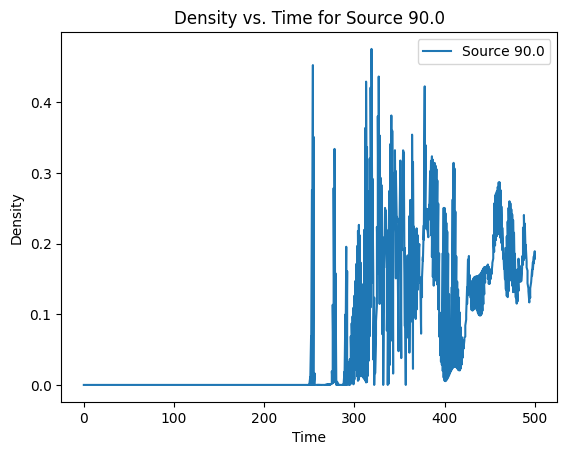

In [99]:
## This graph has both smoke detectors 
import matplotlib.pyplot as plt

# Choose the source for which you want to plot
target_source = 90.0  # Replace with the specific source value you want

# Filter data for the target source
source_data = combined_tensor[combined_tensor[:, 0] == target_source]

# Extract time and density values
time_values = source_data[:, 1].numpy()
density_values = source_data[:, 4].numpy()

# Plot the data
plt.plot(time_values, density_values, label=f'Source {target_source}', linestyle ='-')


# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Density')
plt.title(f'Density vs. Time for Source {target_source}')
plt.legend()
plt.show()



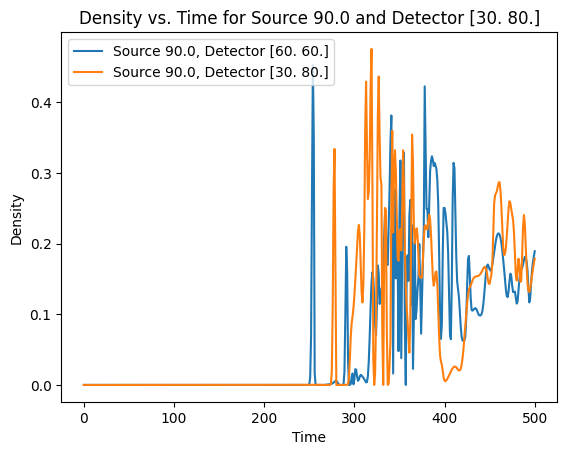

In [98]:
## for all the smoke detecots location
for detector_position in smoke_detectors:
    filtered_data = combined_tensor[
        (combined_tensor[:, 0] == target_source) & 
        (combined_tensor[:, 2] == detector_position[0]) & 
        (combined_tensor[:, 3] == detector_position[1])
    ]
    time_values = filtered_data[:, 1].numpy()
    density_values = filtered_data[:, 4].numpy()  # Assuming density is in the last column (index 4)
    
    # Plot the data
    plt.plot(time_values, density_values, label=f'Source {target_source}, Detector {detector_position}', linestyle='-')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Density')
plt.title(f'Density vs. Time for Source {target_source} and Detector {detector_position}')
plt.legend()
plt.show()

In [40]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
dataset = TensorDataset(input_tensor, target_tensor)


In [41]:
# Define the size of the training set (80% of the data, adjust as needed)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 64


In [42]:

# Create DataLoader for training set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(8, 16)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x
         

input_size = 2  # Assuming you have 2 input features: density and time
model = RegressionModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters())



In [51]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch in train_dataloader:

        inputs, targets = batch
    
        # Forward pass
        outputs = model(inputs)
        

        targets = targets.view(-1, 1)
        # print("Outputs shape:", outputs.shape)
        # print("Target locations shape:", target_locations.shape)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Adjust max_norm as needed
        optimizer.step()

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/100], Loss: 569.4264526367188
Epoch [2/100], Loss: 880.0457763671875
Epoch [3/100], Loss: 569.9281005859375
Epoch [4/100], Loss: 537.6636962890625
Epoch [5/100], Loss: 663.8975830078125
Epoch [6/100], Loss: 698.256103515625
Epoch [7/100], Loss: 651.1347045898438
Epoch [8/100], Loss: 475.540771484375
Epoch [9/100], Loss: 671.6817626953125
Epoch [10/100], Loss: 709.1997680664062
Epoch [11/100], Loss: 502.0511169433594
Epoch [12/100], Loss: 706.0294799804688
Epoch [13/100], Loss: 667.0574340820312
Epoch [14/100], Loss: 874.2660522460938
Epoch [15/100], Loss: 642.2071533203125
Epoch [16/100], Loss: 545.2147216796875
Epoch [17/100], Loss: 635.757568359375
Epoch [18/100], Loss: 952.5021362304688
Epoch [19/100], Loss: 809.1471557617188
Epoch [20/100], Loss: 650.1818237304688
Epoch [21/100], Loss: 576.8011474609375
Epoch [22/100], Loss: 644.8955688476562
Epoch [23/100], Loss: 432.02325439453125
Epoch [24/100], Loss: 642.0560302734375
Epoch [25/100], Loss: 837.494384765625
Epoch [26/10

In [49]:
model.eval()  # Set the model to evaluation mode (important for layers like dropout)
test_loss = 0.0
with torch.no_grad():  # No need to compute gradients during testing
    for batch in test_dataloader:
        inputs, targets = batch

        # Forward pass
        outputs = model(inputs)
        targets = targets.view(-1, 1)

        # Compute the loss
        test_loss += criterion(outputs, targets).item()

# Calculate average test loss
average_test_loss = test_loss / len(test_dataloader)

print(f'Average Test Loss: {average_test_loss}')

Average Test Loss: 638.3345168541217


In [81]:
############ with multiple smoke detectors for one single source trying to fidn something not happy because lot of issues with single source
## Load imbalance - feels like model is biased towards the majority class could be because of that perofomacne is good 

import torch
import h5py
import numpy as np

smoke_detectors = np.array([[60.0, 60.0],[30.0,80.0],[50.0,50.0],[20.0,20.0]])

# Open the HDF5 file
with h5py.File('Smoke Flow Data.h5', 'r') as hf:
    # Initialize lists to store time, x, y, and density values
    all_time_values = []
    all_x_values = []
    all_y_values = []
    all_density_values = []
    all_source_values = []

    # Loop through groups in the file
    # group = hf[source_group]
    #     density_dataset = group['density']
    #     source_value = float(source_group.split('-')[-1])
    source_group = 'x-90.0'
    group = hf[source_group]
    density_dataset = group['density']
    source_value = float(source_group.split('-')[-1])

        # Loop through time steps
    for t in range(density_dataset.shape[0]):
            # Loop through each smoke detector position
        for smoke_detector_pos in smoke_detectors:
            x, y = smoke_detector_pos

                # Extract density value at time t, position (x, y)
            density_value = density_dataset[t, int(x), int(y), 0]  # assuming vector component 0

                # print(x,y)
                # Append the source, time, x, y, and density values to the lists
            all_source_values.append(source_value)  
            all_time_values.append(t)
                # all_x_values.append(x)
                # all_y_values.append(y)
            all_density_values.append(density_value)
                # print(source_value,t,density_value)
                
# Convert lists to PyTorch tensors
source_tensor = torch.tensor(all_source_values, dtype=torch.float32)
time_tensor = torch.tensor(all_time_values, dtype=torch.float32)
density_tensor = torch.tensor(all_density_values, dtype=torch.float32)
# x_tensor = torch.tensor(all_x_values, dtype=torch.float32)
# y_tensor = torch.tensor(all_y_values, dtype=torch.float32)
# print(x_tensor)

In [45]:
print(time_tensor.shape)
print(density_tensor.shape)
print(source_tensor.shape)

torch.Size([2004])
torch.Size([2004])
torch.Size([2004])


In [82]:
# Combine the tensors along the second dimension
combined_tensor = torch.stack((source_tensor, time_tensor, density_tensor), dim=1)

dataset_timeden = torch.stack((source_tensor, time_tensor, density_tensor), dim=1)


# Combine time and density into one input tensor
# input_tensor = torch.cat((time_tensor,x_tensor, y_tensor, density_tensor), 1)
# input_tensor1 = torch.cat((dataset_timeden[:, 1:4], dataset_timeden[:, 5:]), 1)
# input_tensor = torch.cat((dataset_timeden[:, 1:5], dataset_timeden[:, 6:]), 1)

input_tensor = dataset_timeden[:, 1:3]
target_tensor = dataset_timeden[:, 0]

print(input_tensor.shape)
# print("inputtnesor", input_tensor[180])

# print(input_tensor1.shape)
print(target_tensor.shape)



torch.Size([2004, 2])
torch.Size([2004])


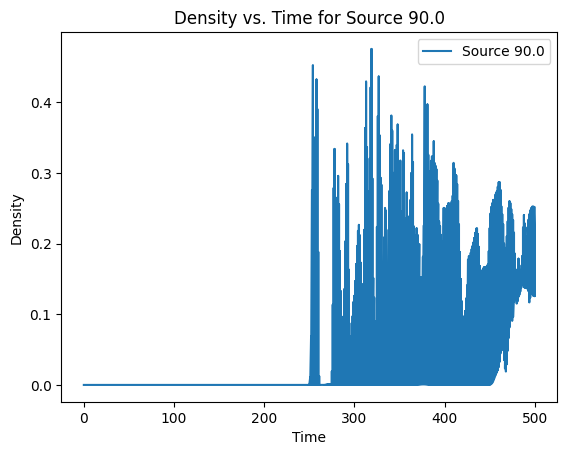

In [83]:
import matplotlib.pyplot as plt

# Choose the source for which you want to plot
target_source = 90.0  # Replace with the specific source value you want

# Filter data for the target source
source_data = combined_tensor[combined_tensor[:, 0] == target_source]

# Extract time and density values
time_values = source_data[:, 1].numpy()
density_values = source_data[:, 2].numpy()

# Plot the data
plt.plot(time_values, density_values, label=f'Source {target_source}', linestyle ='-')


# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Density')
plt.title(f'Density vs. Time for Source {target_source}')
plt.legend()
plt.show()




In [84]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
dataset = TensorDataset(input_tensor, target_tensor)


# Define the size of the training set (80% of the data, adjust as needed)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 32


# Create DataLoader for training set
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(64, 16)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 8)
        self.relu3 = nn.ReLU()
        self.output_layer = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.output_layer(x)
        return x
         

input_size = 2  # Assuming you have 2 input features: density and time
model = RegressionModel(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
# optimizer = optim.SGD(model.parameters(), lr=0.002)
optimizer = optim.Adam(model.parameters())


# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch in train_dataloader:

        inputs, targets = batch
    
        # Forward pass
        outputs = model(inputs)
        

        targets = targets.view(-1, 1)
        # print("Outputs shape:", outputs.shape)
        # print("Target locations shape:", target_locations.shape)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Adjust max_norm as needed
        optimizer.step()

    # Print the loss after each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
model.eval()  # Set the model to evaluation mode (important for layers like dropout)
test_loss = 0.0
with torch.no_grad():  # No need to compute gradients during testing
    for batch in test_dataloader:
        inputs, targets = batch

        # Forward pass
        outputs = model(inputs)
        targets = targets.view(-1, 1)

        # Compute the loss
        test_loss += criterion(outputs, targets).item()

# Calculate average test loss
average_test_loss = test_loss / len(test_dataloader)

print(f'Average Test Loss: {average_test_loss}')

Epoch [1/100], Loss: 1986.27490234375
Epoch [2/100], Loss: 2111.00390625
Epoch [3/100], Loss: 3810.846923828125
Epoch [4/100], Loss: 1476.7786865234375
Epoch [5/100], Loss: 4341.02685546875
Epoch [6/100], Loss: 1629.1070556640625
Epoch [7/100], Loss: 1096.4215087890625
Epoch [8/100], Loss: 2682.13134765625
Epoch [9/100], Loss: 5097.96923828125
Epoch [10/100], Loss: 2306.231201171875
Epoch [11/100], Loss: 5112.76318359375
Epoch [12/100], Loss: 2515.58544921875
Epoch [13/100], Loss: 3419.0087890625
Epoch [14/100], Loss: 2246.112548828125
Epoch [15/100], Loss: 130.2472686767578
Epoch [16/100], Loss: 536.7384643554688
Epoch [17/100], Loss: 2758.6845703125
Epoch [18/100], Loss: 71.03101348876953
Epoch [19/100], Loss: 1006.5219116210938
Epoch [20/100], Loss: 63.952850341796875
Epoch [21/100], Loss: 50.3447380065918
Epoch [22/100], Loss: 33.158145904541016
Epoch [23/100], Loss: 53.313720703125
Epoch [24/100], Loss: 0.45200660824775696
Epoch [25/100], Loss: 12.442970275878906
Epoch [26/100], L

1st  meeting :
just figuring out the model architecture

Things to talk in next meet up:
can we check for all source - is it feasible
are we sure about the input features 
can we use soemhting than the LR 